# Part 1: Bike Share EDA

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.


I intend to reveal what is driving demand for bike hires. Machine learning models will be used to determine which features in the dataset are encouraging people to hire these bikes. Finally we will examine if it is necessary to examine “casual” users and “registered” users separately.


Data source: https://www.kaggle.com/c/bike-sharing-demand/data

Data Fields:

datetime - hourly date + timestamp  

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather -   1: Clear, Few clouds, Partly cloudy, Partly cloudy 
            2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
            3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
            4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
            
temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../Bike share data.csv')

### General observations

In [3]:
#check first few rows to get a sense of what's going on
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


The first column will need breaking up. Demand for bikes will change depending
on the hour and the day of the week. I might guess the month would have an impact due to weather conditions but the data already contains variables about the weather.

'season' could be useful. It should be separated into categories.

'atemp' is an interesting variable, its likely the model wont need both temperature variables.

I imagine 'atemp' is related to humidity and windspeed as well.
We want to know how many bike rentals there will be which can be seen in "count"
but "count" is derived from casual and registered. Perhaps regression models
should be made for the last 3 columns.

In [4]:
#check datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


'datetime' is a time variable (which will be cut up into days of the week which are  categorical)
'season', 'holiday', 'workingday' & 'weather' are categorical
'temp','atemp', 'humidity' & 'windspeed' are continuous variables
There are no missing values

In [5]:
#Examine basic stats
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


Not seeing much difference between the means and medians for the continuous variables which implies there is minimal skew in their distributions.
rental counts are skewed. 
We'll check the residuals for normality of any model we make (except tree based models).
If the residuals are not normal some transformations will be made (See feature engineering notebook).

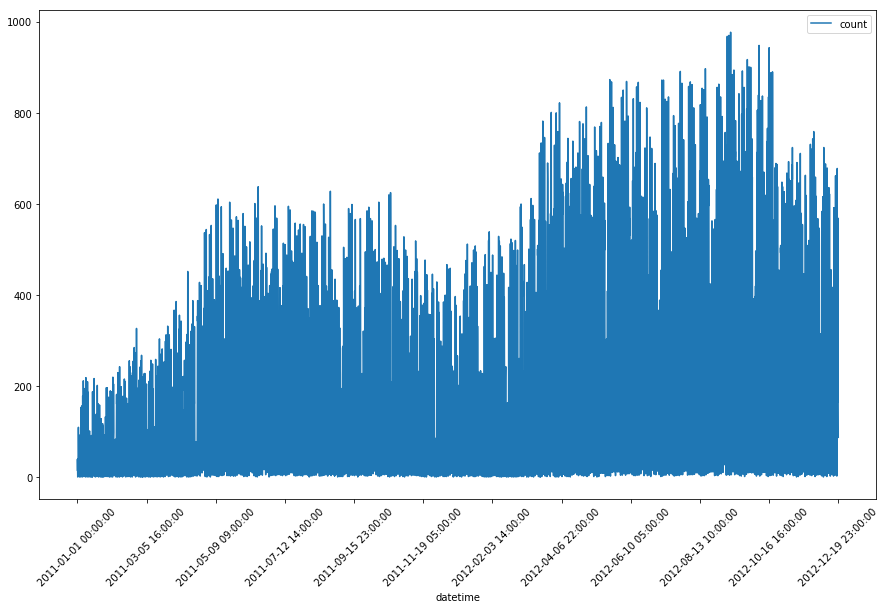

In [6]:
#plot the time series
df[['datetime','count']].plot(y = 'count', x= 'datetime', kind = 'line', xticks = np.linspace(0, len(df)-1,12, dtype=int), figsize = (15,9),rot = 45)

The plot reveals seasonality and an upward trend. Let's limit the number of points plotted so that we can compare 'registered' and 'casual'.

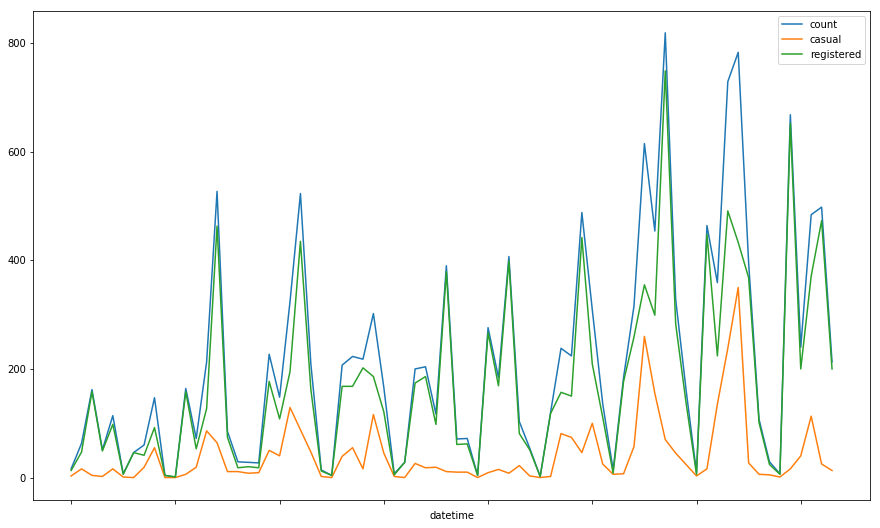

In [7]:
df.loc[np.round(np.linspace(0,len(df), num = 75)).astype(int),['datetime','count','casual','registered']]\
.plot(y = ['count','casual','registered'], x= 'datetime', kind = 'line', figsize = (15,9),rot = 45)

The shape of 'count' is mostly determined by 'registered', though there are occasions where 'casual'
has a significant impact on the shape of 'count'.

### Examination of continuous variables

casual           AxesSubplot(0.125,0.657941;0.227941x0.222059)
registered    AxesSubplot(0.398529,0.657941;0.227941x0.222059)
count         AxesSubplot(0.672059,0.657941;0.227941x0.222059)
dtype: object

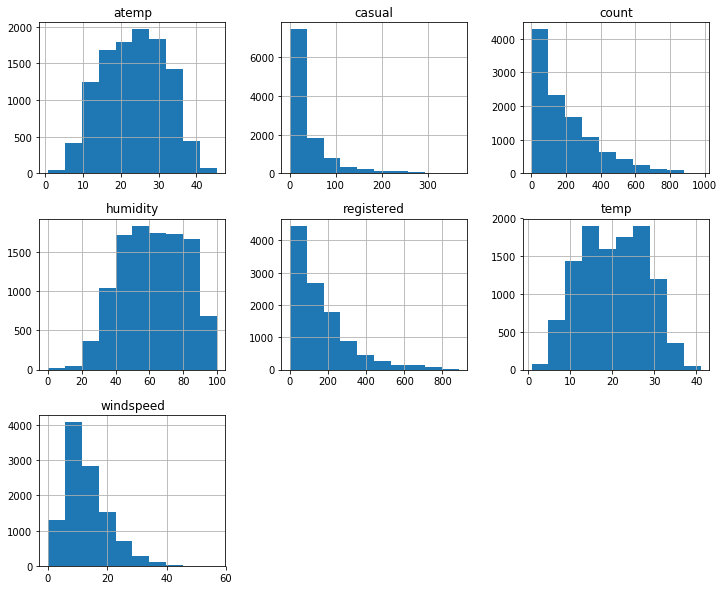

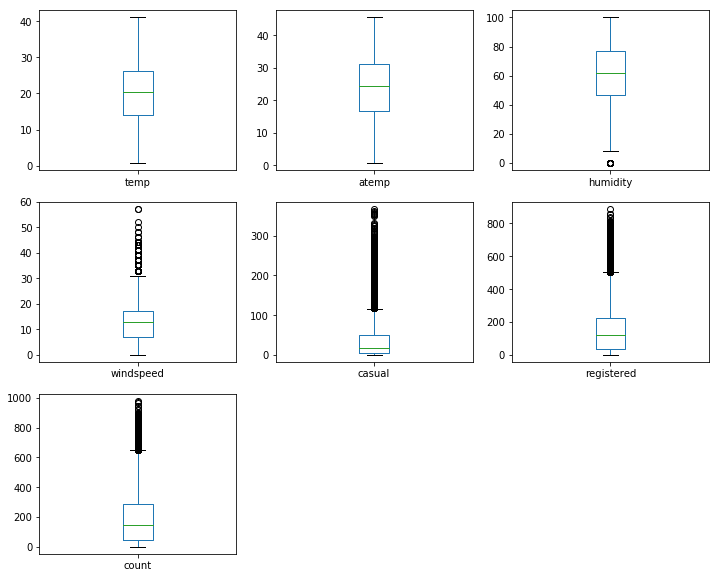

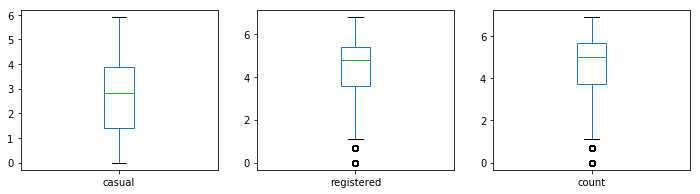

In [8]:
dfCont = df.loc[:,'temp':]

#distributions checks
dfCont.hist(figsize = (12,10))
dfCont.plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(12,10))
dfCont.iloc[:,-3:].apply(np.log).plot(kind= 'box' , subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(12,10))

Independent variables are mostly normally distributed. The counts are not. We see one outlier for
humidity and plenty for windspeed.
If we apply a log transformation (in an attempt to normalise) on the count data there are few outliers.

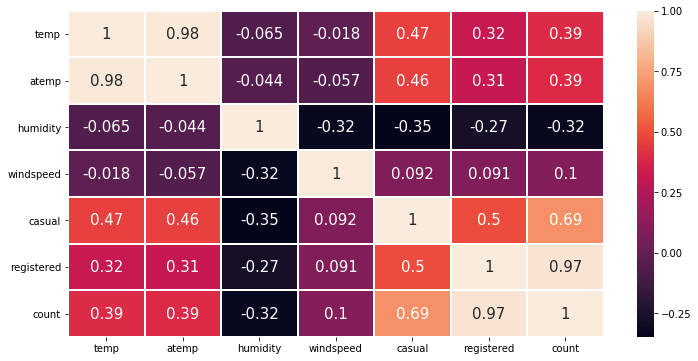

In [9]:
#correlations
plt.figure(figsize = (12,6)); sns.heatmap(dfCont.corr(), linewidths=1, annot = True, annot_kws={"size": 15})

In relation to 'count' we see that most features are positively correlated with the exception of
humidity. Windspeed has almost no correlation (though i cant help but imagine that very strong winds
would discourage bike rentals. Otherwise regular windspeeds should be fine).
'casual' and 'registered' counts are not as correlated as I thought they would be.
its interesting to see that temperature more strongly correlates to 'casual'.
the two temperature variables are strongly correlated to one another and share virtually the
same correlations with all other variables. We wont need both, we could use PCA to combine them so
that we preserve most of their combined variability/information whilst reducing the overfitting
that would come from keeping both.

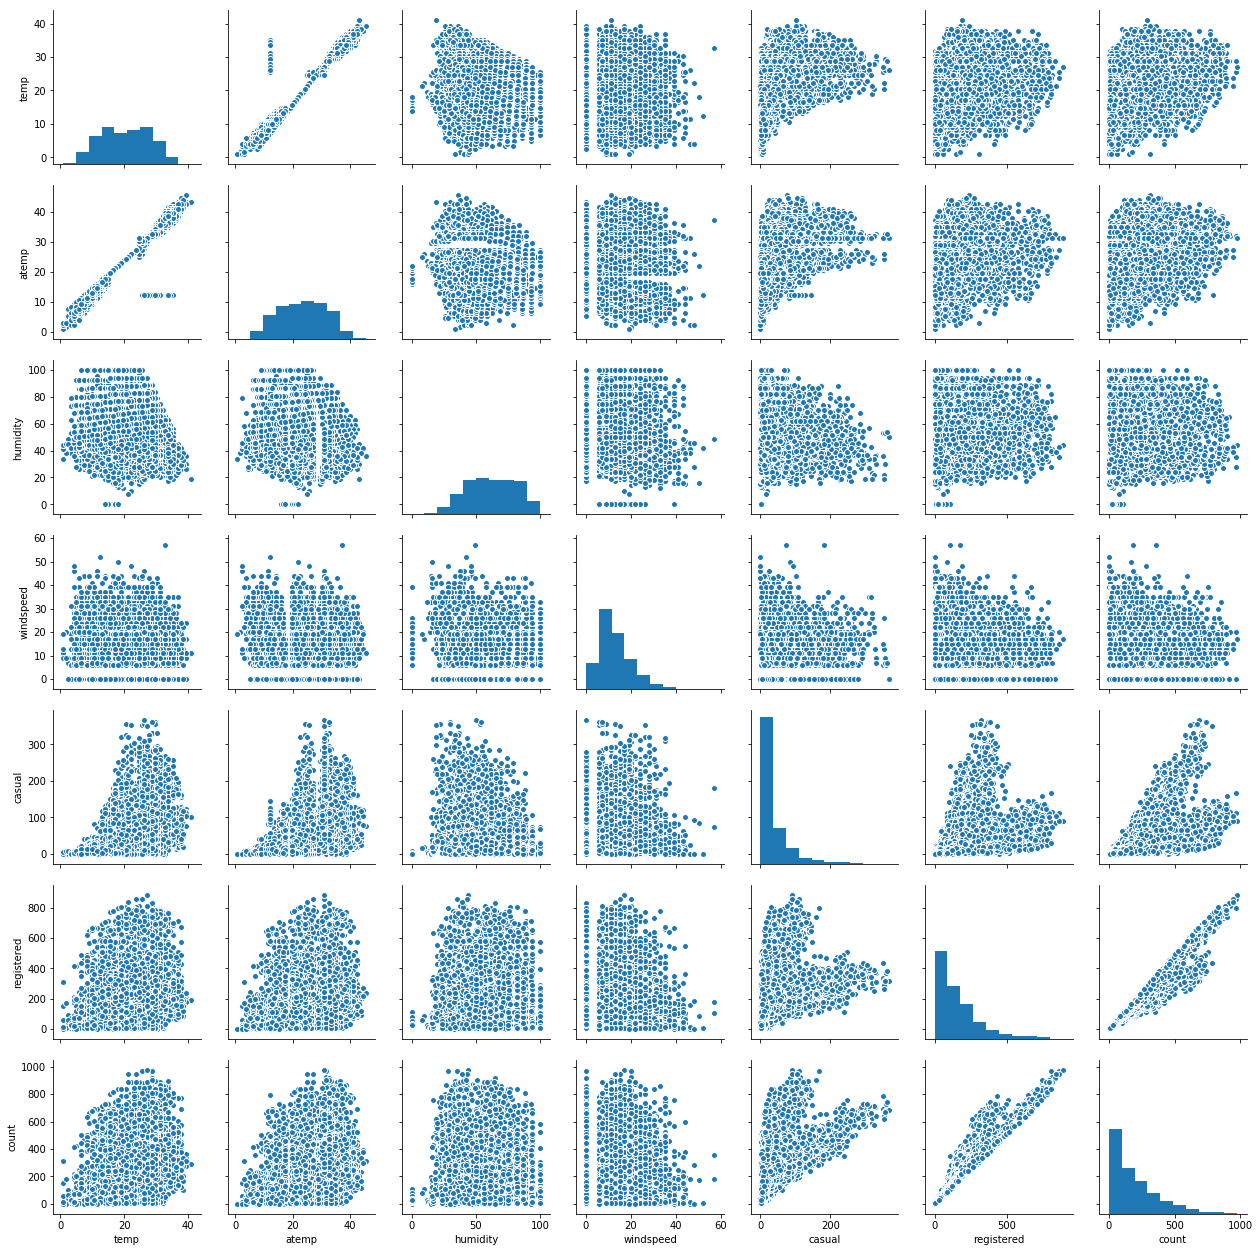

In [10]:
#check scatters
sns.pairplot(dfCont)

There are a few pockets of data that look quite isolated, espicially for temperature. These require more investigation
Windspeed does actually appear to have a relationship with count unless speed is zero. 

In [11]:
#Check if windspeed correlates to count at higher speeds:
for i in [0.7, 0.8, 0.9]:
    print('windspeed-count correlation, windspeed percentile is {} : corr = {}'
          .format(i,round(df[df['windspeed']>df['windspeed'].quantile(i)].corr()['windspeed']['count'],2)))

windspeed-count correlation, windspeed percentile is 0.7 : corr = -0.03
windspeed-count correlation, windspeed percentile is 0.8 : corr = -0.03
windspeed-count correlation, windspeed percentile is 0.9 : corr = -0.08


My hunch was incorrect, winds at high speed still dont have much of a relationship with bike hire counts

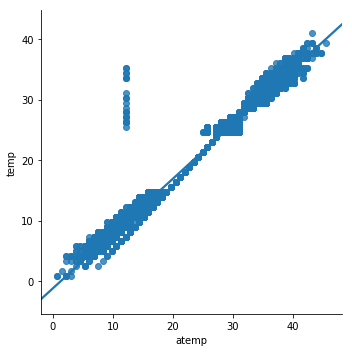

In [12]:
#odd temperature check
sns.lmplot('atemp','temp', data=dfCont)

In [13]:
oddTemp = df[df['atemp']<14][df['temp']<38][df['temp']>25]
oddTemp.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,24.0,24.0,24.0,24.000000,24.000000,2.400000e+01,24.000000,24.000000,24.000000,24.000000,24.000000
mean,3.0,0.0,1.0,1.375000,29.656667,1.212000e+01,57.083333,15.500729,61.791667,236.041667,297.833333
std,0.0,0.0,0.0,0.646899,3.399630,3.629125e-15,16.589459,7.967729,48.699593,186.696564,219.428044
min,3.0,0.0,1.0,1.000000,25.420000,1.212000e+01,30.000000,7.001500,0.000000,6.000000,6.000000
25%,3.0,0.0,1.0,1.000000,26.855000,1.212000e+01,40.250000,8.998100,14.750000,91.750000,112.750000
50%,3.0,0.0,1.0,1.000000,28.290000,1.212000e+01,58.000000,13.999650,57.500000,202.500000,315.500000
75%,3.0,0.0,1.0,2.000000,33.620000,1.212000e+01,70.000000,20.500325,104.250000,332.000000,380.000000
max,3.0,0.0,1.0,3.000000,35.260000,1.212000e+01,83.000000,31.000900,144.000000,647.000000,791.000000


24 consecutive values for atemp are set to 12.12. This must be an error, as such these values must be treated as missing
Since atemp and temp are so well correlated we will fill the missing atemp values with a regression model derived from the two features.

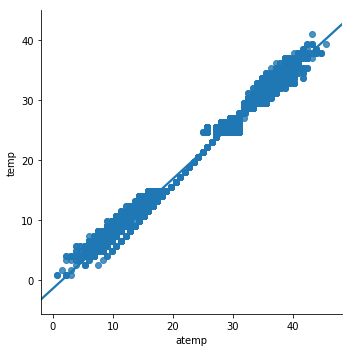

In [14]:
from sklearn.linear_model import LinearRegression
X = df.drop(oddTemp.index)['temp']
y = df.drop(oddTemp.index)['atemp']
lr = LinearRegression()
lr.fit(X.values.reshape(-1,1),y)
atemp_preds = lr.predict(df['temp'].loc[oddTemp.index].values.reshape(-1,1))
df['atemp'][oddTemp.index] = atemp_preds
sns.lmplot('atemp','temp', data=df)

The anomalies have now been cleared up

### Examination of categorical variables

In [15]:
##Let's take a look at the categorical features (time variable will be looked into once we've done some feature engineering)
dfCat = df[['season', 'holiday', 'workingday', 'weather', 'count']]

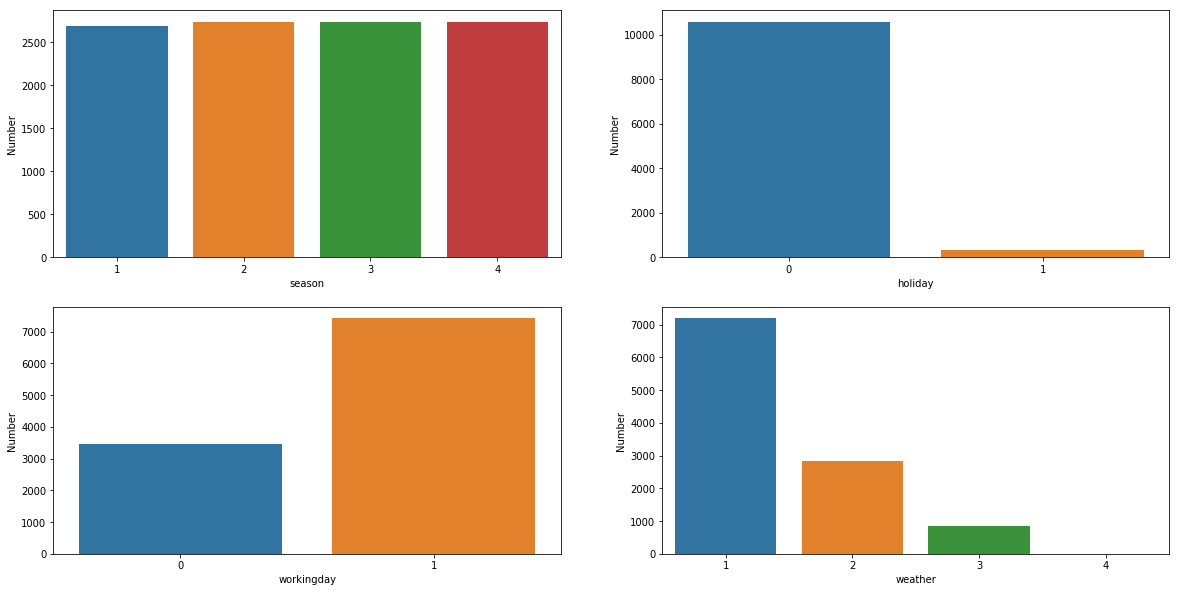

In [16]:
#How are they distributed?
fig, axes = plt.subplots(2,2, figsize=(20, 10))

for i, ax in enumerate(fig.axes):
    if i < len(dfCat.columns[:-1]):
        sns.countplot(x=dfCat.columns[i], data=dfCat, ax=ax)
        ax.set_ylabel('Number')

Nothing remarkable about 'season', there are less values for spring but not significantly so.

As expected non holidays vastly outnumber holidays.

There are just over 2 times as many working days as non working days as expected.

There is almost no data for weather category 4 (Heavy rain etc.)

In [17]:
print('Number of weather category 4: {}'.format(len(df[df['weather']==4])))

Number of weather category 4: 1


Just one value, there will be nothing to learn from it. It will be assigned to category 3 since thats the closest in terms of description. This should reduce any adverse effects in the modelling process that result from having such an unnecessary feature.

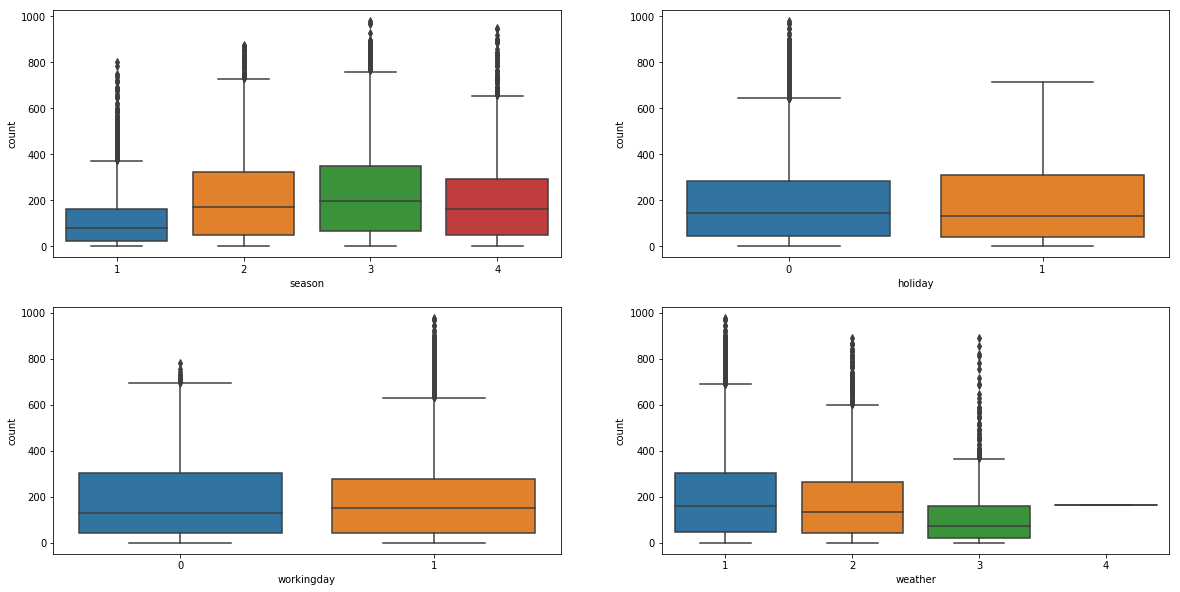

In [18]:
df['weather'][df['weather']==4] = 3

#How do these variables interact with 'count'?
fig, axes = plt.subplots(2,2, figsize=(20, 10))

for i, ax in enumerate(fig.axes):
    if i < len(dfCat.columns[:-1]):
        sns.boxplot(x=dfCat.columns[i], y = 'count',data=dfCat, ax=ax)

There is clearly a seasonal effect. Summer typically has a higher bike hire count. This is followed by Autumn, Winter and then Spring. I wonder if this was weather related, fortunately we have that data.....

Holidays do not seem to have an impact on bike hires. Non holidays have the very largest hire counts.

Median values for working and non working days are almost the same. However working days tend to have the very high count values.

The last two categories indicate that people arent necessary using these bikes for leisure, it is perhaps more common for users to need the bikes for general transportation.

Weather, like seasons also has an impact on bike hire counts. Clear days result in more hires. Cloudy/misty days reduces hires. If there is precipitation then there are much less hires.

Weather distribution across seasons


Text(0.5,15,'weather')

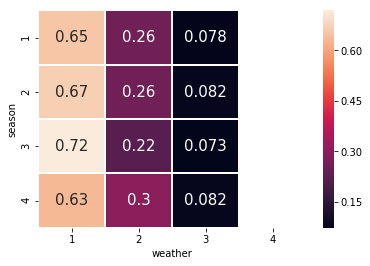

In [19]:
#Examine 'season' and 'weather' together
cross = df[['season','weather','count']].pivot_table(index='season', columns = 'weather', aggfunc='count')
cross.columns = cross.columns.droplevel()
print('Weather distribution across seasons')
sns.heatmap(cross/cross.sum(axis=1), linewidths=1, annot = True, annot_kws={"size": 15}).set_xlabel('weather')

Spring's weather appears worse than Summer and Autumn but not worse than Winter

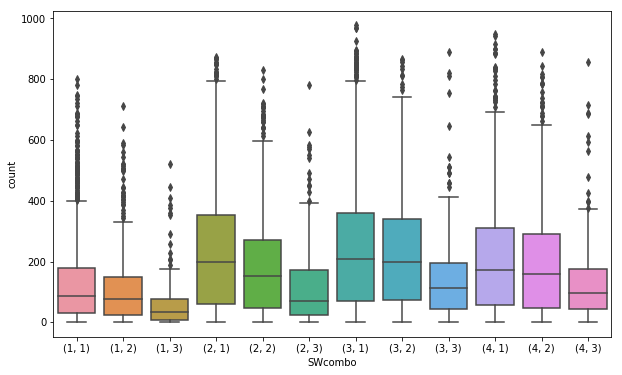

In [20]:
dfCat['SWcombo']=list(zip(df['season'],df['weather']))
plt.figure(figsize=(10,6)); sns.boxplot(x='SWcombo', y = 'count',data=dfCat.sort_values('SWcombo'))

Bad weather has a negative effect no matter the season. Cloudy days are more impactful in the summer

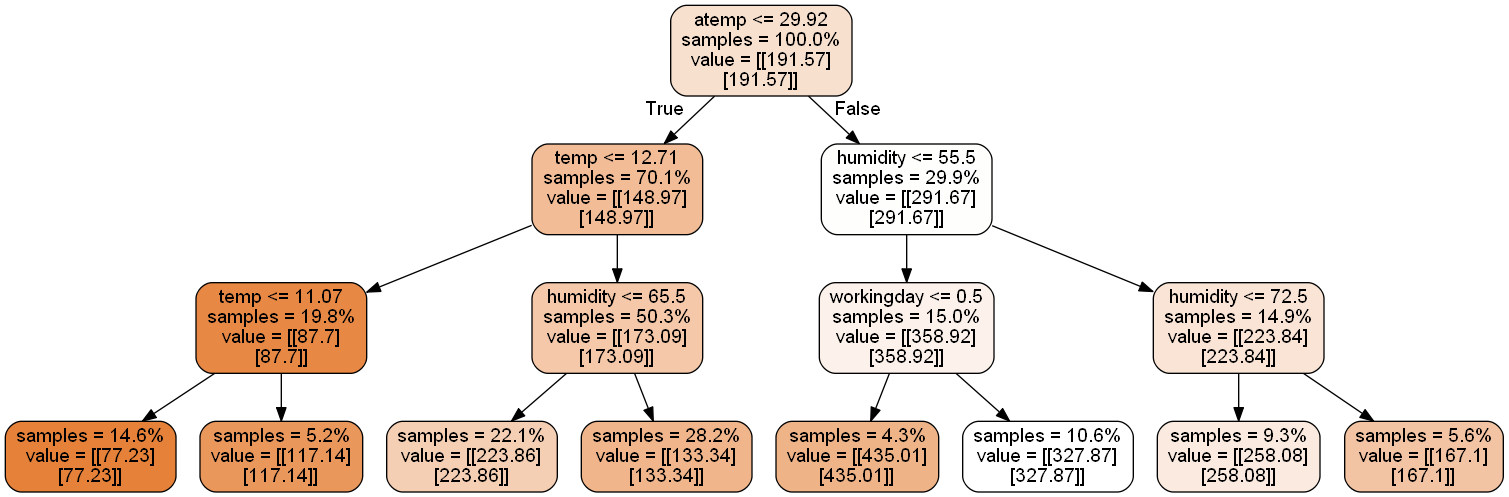

In [21]:
#Even though this is an EDA I cant help but sneak in a regression tree so that feature impact on 'count' can be further visualised. 
#Code is sloppy but should still present us with a revealing tree
dums = pd.get_dummies(dfCat.iloc[:,:-1])
df2 = pd.concat((dums, dfCont), axis =1)
df2 = df2.fillna(df2.mean())

from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

from sklearn.tree import DecisionTreeRegressor

rTree = DecisionTreeRegressor(max_depth=3)
rTree.fit(df2.drop(['count','casual','registered'], axis=1),df2['count'])

dot_data = StringIO()  
export_graphviz(rTree, out_file=dot_data,feature_names=df2.drop(['count','casual','registered'], axis=1).columns ,filled=True, rounded = True, proportion = True, precision = 2, impurity = False)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())

atemp, temp, humidity and workingday all seem to play a significant role in determining bike hire counts
let's recall that humidity was negatively correlated to count. People prefer to hire bikes on drier days.
Tree indicates that working days actually lower  bike hires

In [22]:
#Save modified data in preparation for PART 2: Feature Engineering
#df['datetime'] = pd.to_datetime(df['datetime'])
#df.to_csv('./Bike share data (atemp-weather fix).csv', index=False)